In [355]:
import pandas as pd 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn.preprocessing import StandardScaler
import numpy as np 
from tensorflow.keras.datasets import mnist
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [356]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print(train_y)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
[5 0 4 ... 5 6 8]


In [357]:
train_X = train_X.reshape(len(train_X), 28*28)
test_X = test_X.reshape(len(test_X), 28*28)
print('X_train: ' + str(train_X.shape))
print('X_test:  '  + str(test_X.shape))

X_train: (60000, 784)
X_test:  (10000, 784)


In [358]:
train_X = train_X.astype('float32') 
test_X = test_X.astype('float32')

train_X = train_X/255.0
test_X = test_X/255.0

In [359]:
from sklearn.cluster import MiniBatchKMeans

total_clusters = len(np.unique(test_y))
print(total_clusters)

kmeans_10 = MiniBatchKMeans(n_clusters = total_clusters)
kmeans_10.fit(train_X)

10


MiniBatchKMeans(n_clusters=10)

In [360]:
trains_pred_y = kmeans_10.predict(train_X)
print(train_y[0:20])
print(trains_pred_y[0:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[3 8 4 5 7 0 5 3 5 6 2 5 2 9 5 6 0 3 9 6]


In [361]:
def match_clusters(y, y_pred):
    reference_labels = {}
    for i in range(len(np.unique(y_pred))):
        index = np.where(y_pred == i,1,0)
        # print(i, np.bincount(y[index==1]))
        num = np.bincount(y[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [362]:
def match_clusters_swap(reference_labels, trains_pred_y):
    number_labels = np.array([0] * len(trains_pred_y))
    for i in range(len(trains_pred_y)):
        number_labels[i] = reference_labels[trains_pred_y[i]]
    return number_labels

In [363]:
reference_labels_10 = match_clusters(train_y, trains_pred_y)
print(reference_labels_10)

trains_pred_y_matched = match_clusters_swap(reference_labels_10, trains_pred_y)

print(train_y[0:20])
print(trains_pred_y_matched[0:20])

{0: 2, 1: 7, 2: 3, 3: 8, 4: 4, 5: 1, 6: 7, 7: 4, 8: 0, 9: 6}
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[8 0 4 1 4 2 1 8 1 7 3 1 3 6 1 7 2 8 6 7]


In [364]:
def print_stats (model, train_y, trains_pred_y):
    print('Inertia : ' + str(format(model.inertia_)))
    print('Homogeneity : ' + str(metrics.homogeneity_score(trains_pred_y, train_y)))
    print('Accuracy score : ' + str(accuracy_score(train_y, trains_pred_y)))

In [365]:
print("Train set stats")
print_stats(kmeans_10, train_y, trains_pred_y_matched)

print("\nTesting set stats")
test_pred_y = kmeans_10.predict(test_X)
test_pred_y_matched = match_clusters_swap(reference_labels_10, test_pred_y)
print_stats(kmeans_10, test_y, test_pred_y_matched)

Train set stats
Inertia : 2373841.0
Homogeneity : 0.548718107578577
Accuracy score : 0.6102333333333333

Testing set stats
Inertia : 2373841.0
Homogeneity : 0.5614077964457328
Accuracy score : 0.6129


# Testing with different number of clusters

In [366]:
cluster_nums = [16, 32, 64, 128, 256]
models = []
reference_maps = []


for clust_num in cluster_nums:
    print("CLUSTERS: " + str(clust_num))
    kmeans_temp = MiniBatchKMeans(n_clusters = clust_num)
    kmeans_temp.fit(train_X)
    trains_pred_y = kmeans_temp.predict(train_X)

    reference_labels = match_clusters(train_y, trains_pred_y)

    trains_pred_y_matched = match_clusters_swap(reference_labels, trains_pred_y)

    print("Train set stats")
    print_stats(kmeans_temp, train_y, trains_pred_y_matched)

    print("\nTesting set stats")
    test_pred_y = kmeans_temp.predict(test_X)
    test_pred_y_matched = match_clusters_swap(reference_labels, test_pred_y)
    print_stats(kmeans_temp, test_y, test_pred_y_matched)
    print("\n")

    models.append(kmeans_temp)
    reference_maps.append(reference_labels)

    

CLUSTERS: 16
Train set stats
Inertia : 2223600.75
Homogeneity : 0.5503518952496524
Accuracy score : 0.6433666666666666

Testing set stats
Inertia : 2223600.75
Homogeneity : 0.5639674505962383
Accuracy score : 0.6592


CLUSTERS: 32
Train set stats
Inertia : 1983094.25
Homogeneity : 0.6443146687444096
Accuracy score : 0.7541833333333333

Testing set stats
Inertia : 1983094.25
Homogeneity : 0.6584408135788158
Accuracy score : 0.7648


CLUSTERS: 64
Train set stats
Inertia : 1805311.75
Homogeneity : 0.707892993779067
Accuracy score : 0.8262

Testing set stats
Inertia : 1805311.75
Homogeneity : 0.7211219664512292
Accuracy score : 0.8352


CLUSTERS: 128
Train set stats
Inertia : 1647326.5
Homogeneity : 0.7706325286789636
Accuracy score : 0.8791166666666667

Testing set stats
Inertia : 1647326.5
Homogeneity : 0.7724855023739693
Accuracy score : 0.8798


CLUSTERS: 256
Train set stats
Inertia : 1506552.0
Homogeneity : 0.7904640175532957
Accuracy score : 0.8937666666666667

Testing set stats
Iner

# Visulaize centroids

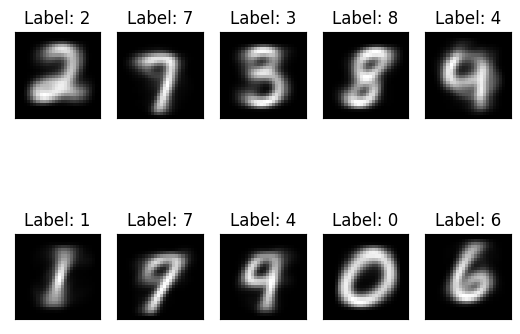

In [374]:
import matplotlib.pyplot as plt

centroids = kmeans_10.cluster_centers_.reshape((10, 28, 28))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(centroids[i], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(reference_labels_10[i]))
  plt.xticks([])
  plt.yticks([])

(32, 28, 28)


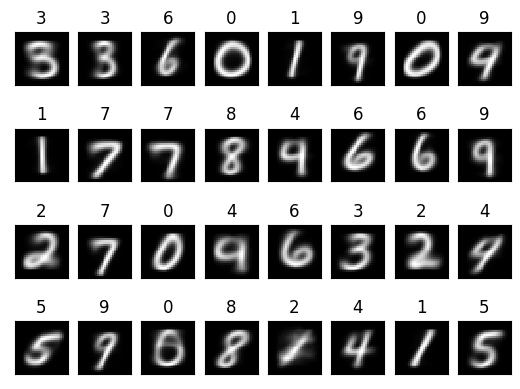

In [388]:
index = 1
cn = cluster_nums[index]
centroids = models[index].cluster_centers_.reshape((cn, 28, 28))
# print(centroids.shape)


for i in range(cn):
  plt.subplot(4,8,i+1)
  plt.imshow(centroids[i], cmap='gray', interpolation='none')
  plt.title("{}".format(reference_maps[index][i]))
  plt.xticks([])
  plt.yticks([])

(128, 28, 28)


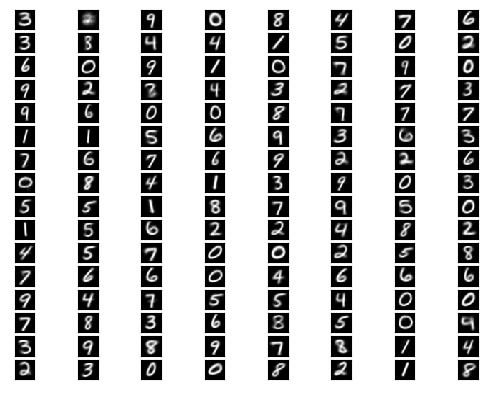

In [391]:
index = 3
cn = cluster_nums[index]
centroids = models[index].cluster_centers_.reshape((cn, 28, 28))
# print(centroids.shape)


for i in range(cn):
  plt.subplot(16,8,i+1)
  plt.imshow(centroids[i], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])